<a href="https://colab.research.google.com/github/sindhu213/Research-Papers/blob/master/src/NMT_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchdata

## Neural machine translation by jointly learning to align and translate

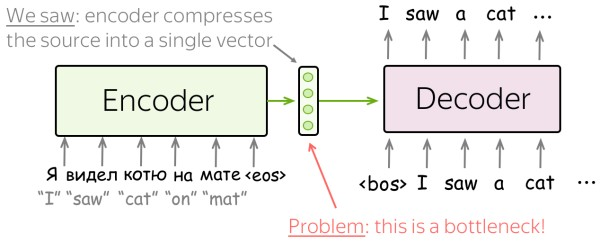

Image Source: [Lena Voita NLP](https://lena-voita.github.io/nlp_course/seq2seq_and_attention.html)

<font size="4">In an **Encoder-Decoder** architecture, a source sentence is encoded into a fixed-length context representation (which subsequently initializes the decoder network's hidden state, h<sub>0</sub>). Though it provides some context to the decoder network, it generally leads to information loss due to data compression   (most likely in long source sentences). </font>

<font size="4"> [*Bahdanau et al. (2016)*](https://arxiv.org/pdf/1409.0473.pdf?utm_source=ColumnsChannel) proposes a method to mitigate this problem by allowing the network to automatically search for a part of the source sentence that can predict the target token at each decoding step. It accomplishes this through the use of attention. </font>

# Preparing Data

In [ ]:
import re
import random
from typing import Tuple

import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence

from torchtext.datasets import Multi30k
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
## train dtype: torch.utils.data.datapipes.iter.grouping.ShardingFilterIterDataPipe
train,valid,test = Multi30k()

In [ ]:
def tokenize(string):
  tokenized = re.sub(r'[^\w\s]',' ',string.lower())
  return tokenized.split()

def yield_tokens(data_iter,lang):
  for de,en in data_iter:
    if lang is 'en': yield tokenize(en)
    else: yield tokenize(de)

In [ ]:
en_vocab = build_vocab_from_iterator(yield_tokens(train,'en'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
en_vocab.set_default_index(0)

de_vocab = build_vocab_from_iterator(yield_tokens(train,'de'),min_freq=2,specials=["<unk>","<pad>","<bos>","<eos>"])
de_vocab.set_default_index(0)

In [ ]:
print("No. of unique tokens in en_vocab: ",len(en_vocab))
print("No. of unique tokens in de_vocab: ",len(de_vocab))

No. of unique tokens in en_vocab:  5883
No. of unique tokens in de_vocab:  7860


In [ ]:
de_pipeline = lambda x: de_vocab(["<bos>",*tokenize(x),"<eos>"])
en_pipeline = lambda x: en_vocab(["<bos>",*tokenize(x),"<eos>"])

In [ ]:
class TextDataset(Dataset):

  def __init__(self,datapipe) -> None:
    self.dp = list(datapipe)

  def __len__(self) -> int:
    return len(self.dp)

  def __getitem__(self,idx) -> Tuple[str,str]:
    return self.dp[idx]

train_data = TextDataset(train)
valid_data = TextDataset(valid)
test_data = TextDataset(test)

In [ ]:
print(f"len (train_data) : {len(train_data)}")
print(f"len (valid_data) : {len(valid_data)}")
print(f"len (test_data)  : {len(test_data)}")

len (train_data) : 29001
len (valid_data) : 1015
len (test_data)  : 1000


In [ ]:
def collate_batch(data):
  de,en_data,en_label = [], [], []
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  for (x_batch,y_batch) in data:
    src_encoded = de_pipeline(x_batch)
    src.append(torch.tensor(src_encoded,dtype=torch.int64))
    tgt_encoded = en_pipeline(y_batch)
    tgt_data.append(torch.tensor(tgt_encoded[:-1],dtype=torch.int64))
    tgt_label.append(torch.tensor(tgt_encoded[1:],dtype=torch.int64))
  
  src = pad_sequence(src,batch_first=True,padding_value=1)
  tgt_data = pad_sequence(tgt_data,batch_first=True,padding_value=1)
  tgt_label = pad_sequence(tgt_label,batch_first=True,padding_value=1)

  return src.to(device),tgt_data.to(device),tgt_label.to(device)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True,collate_fn=collate_batch)
valid_dl = DataLoader(valid_data,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)
test_dl = DataLoader(test_data,batch_size=batch_size,shuffle=False,drop_last=True,collate_fn=collate_batch)

# Model Definition